# Classify Building Conditions in Zanzibar from Drone Imagery

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import fastai
print(fastai.__version__)

1.0.28


## Prepare Data

In [28]:
path = Path('/storage/classify-data')

In [30]:
path_img = path/'images'

In [31]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

20176


[PosixPath('/storage/classify-data/images/grid043_04750_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid058_05520_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid029_00149_Complete.jpg'),
 PosixPath('/storage/classify-data/images/grid042_02150_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid035_00463_Foundation.jpg')]

In [32]:
# filter out empty jpg files by size>0 and sort
fnames = [fname.name for fname in sorted(fnames) if os.path.getsize(fname)>0]
print(len(fnames))
fnames[:5]

20176


['grid001_00001_Complete.jpg',
 'grid001_00002_Complete.jpg',
 'grid001_00003_Complete.jpg',
 'grid001_00004_Complete.jpg',
 'grid001_00005_Complete.jpg']

In [33]:
df = pd.DataFrame(fnames,columns=['fnames'])
df.head()

fnames
0  grid001_00001_Complete.jpg
1  grid001_00002_Complete.jpg
2  grid001_00003_Complete.jpg
3  grid001_00004_Complete.jpg
4  grid001_00005_Complete.jpg

In [34]:
# hand-picked val grids
holdout_grids = ['grid028_','grid029_','grid042_','grid058_']
valid_idx = [i for i,o in df.iterrows() if any(c in str(o.fnames) for c in holdout_grids)]

In [35]:
df.iloc[valid_idx].head()

fnames
7432     grid028_00000_Empty.jpg
7433  grid028_00001_Complete.jpg
7434  grid028_00002_Complete.jpg
7435  grid028_00003_Complete.jpg
7436  grid028_00004_Complete.jpg

In [36]:
# pulled out of fastai/data.py
pat = r'([^_]+).jpg$'
pat = re.compile(pat)
def get_label(fn): return pat.search(str(fn)).group(1)

In [37]:
src = (ImageItemList.from_df(df, folder='images', path=path)
        .split_by_idx(valid_idx)
        .label_from_func(get_label))

In [38]:
bs = 48 # biggest batch size that'll fit within 24GB gpu mem (Paperspace P6000), adjust down to fit your machine
sz = 512
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=0, max_lighting=0.3)
data = (src.transform(tfms, size=512, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [39]:
data

ImageDataBunch;
Train: LabelList
y: CategoryList (14833 items)
[Category Complete, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (14833 items)
[Image (3, 428, 920), Image (3, 184, 187), Image (3, 197, 196), Image (3, 157, 157), Image (3, 185, 188)]...
Path: /storage/classify-data;
Valid: LabelList
y: CategoryList (5343 items)
[Category Empty, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (5343 items)
[Image (3, 243, 179), Image (3, 298, 234), Image (3, 186, 221), Image (3, 300, 181), Image (3, 176, 184)]...
Path: /storage/classify-data;
Test: None

In [40]:
data.train_ds.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

Empty /storage/classify-data/images/grid028_00000_Empty.jpg


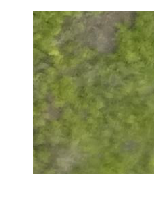

Complete /storage/classify-data/images/grid028_00001_Complete.jpg


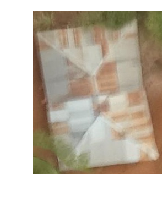

Complete /storage/classify-data/images/grid028_00002_Complete.jpg


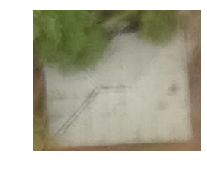

Complete /storage/classify-data/images/grid028_00003_Complete.jpg


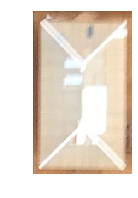

Complete /storage/classify-data/images/grid028_00004_Complete.jpg


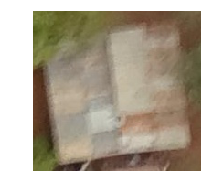

In [41]:
for i in range(5):
    print(data.valid_ds.classes[data.valid_ds.y[i].data], data.valid_ds.items[i]); 
    data.valid_ds.x[i].show()
    plt.show()

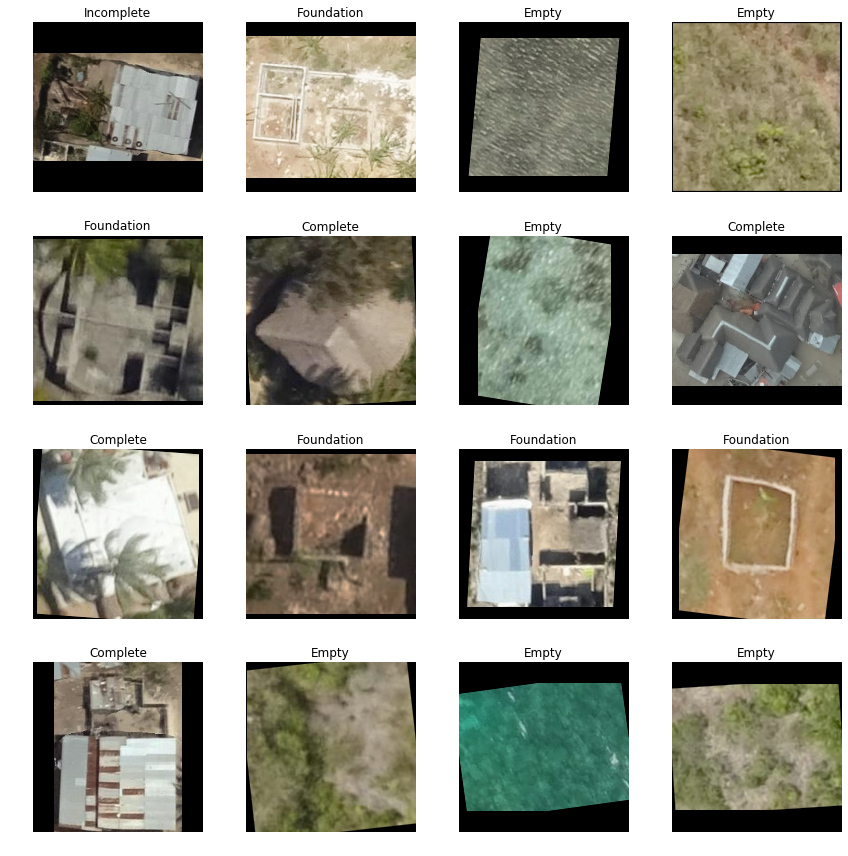

In [42]:
data.show_batch(rows=4, figsize=(12,12))

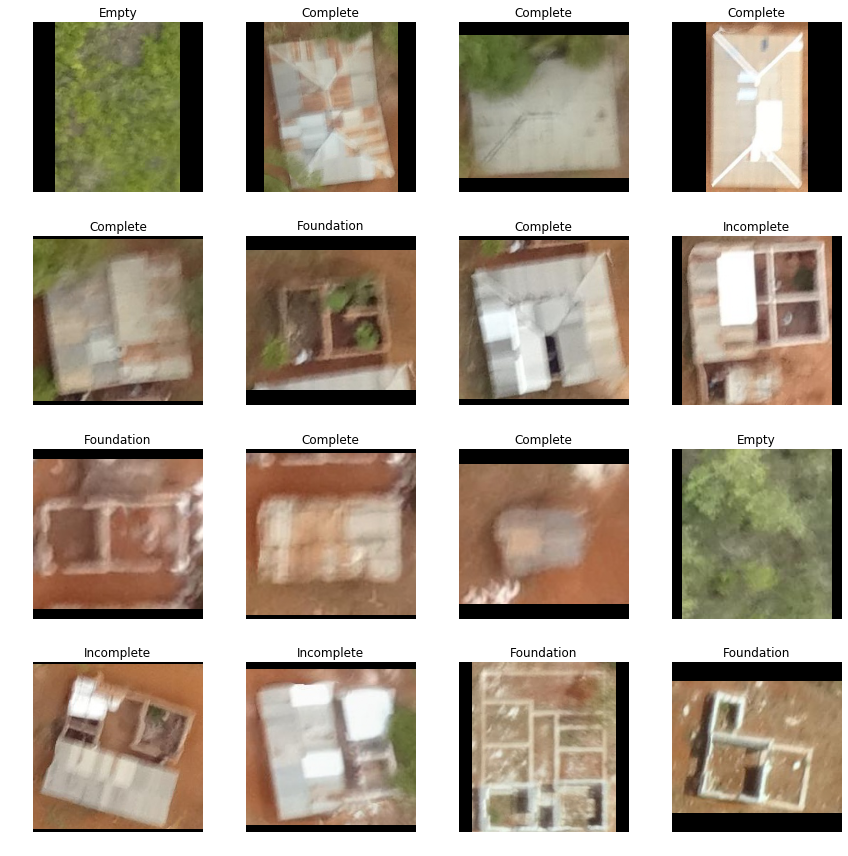

In [45]:
data.show_batch(rows=4, figsize=(12,12), ds_type=DatasetType.Valid)

In [46]:
data.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

## Train with ResNet50

In [22]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


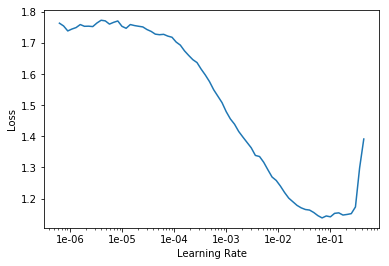

In [23]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(20, max_lr=lr)

Total time: 1:46:54
epoch  train_loss  valid_loss  error_rate
1      0.370103    0.252284    0.091334    (05:26)
2      0.340221    0.222527    0.079356    (05:22)
3      0.327129    0.362051    0.134569    (05:22)
4      0.311903    0.455249    0.168258    (05:21)
5      0.302713    0.239689    0.078982    (05:21)
6      0.311439    0.311619    0.111173    (05:20)
7      0.300200    0.187825    0.069811    (05:20)
8      0.289231    0.266658    0.092832    (05:20)
9      0.272968    0.254518    0.086655    (05:19)
10     0.281558    0.185113    0.064570    (05:19)
11     0.266924    0.273529    0.091709    (05:19)
12     0.252022    0.178103    0.061763    (05:19)
13     0.245933    0.207791    0.073929    (05:19)
14     0.232431    0.167605    0.059891    (05:19)
15     0.207311    0.173096    0.060827    (05:19)
16     0.203006    0.190587    0.062886    (05:20)
17     0.195082    0.180999    0.060079    (05:20)
18     0.198739    0.169363    0.059704    (05:19)
19     0.196992    0

In [28]:
learn.save('20181119-rn50-stage1')

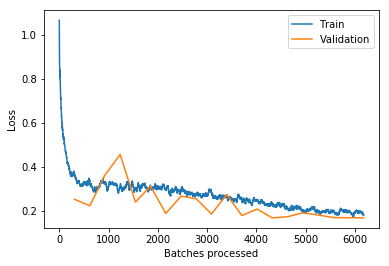

In [29]:
learn.recorder.plot_losses()

## Look at Results

In [47]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 39053194.16it/s]


In [48]:
learn.load('20181119-rn50-stage1')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (14833 items)
[Category Complete, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (14833 items)
[Image (3, 428, 920), Image (3, 184, 187), Image (3, 197, 196), Image (3, 157, 157), Image (3, 185, 188)]...
Path: /storage/classify-data;
Valid: LabelList
y: CategoryList (5343 items)
[Category Empty, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (5343 items)
[Image (3, 243, 179), Image (3, 298, 234), Image (3, 186, 221), Image (3, 300, 181), Image (3, 176, 184)]...
Path: /storage/classify-data;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, strid

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

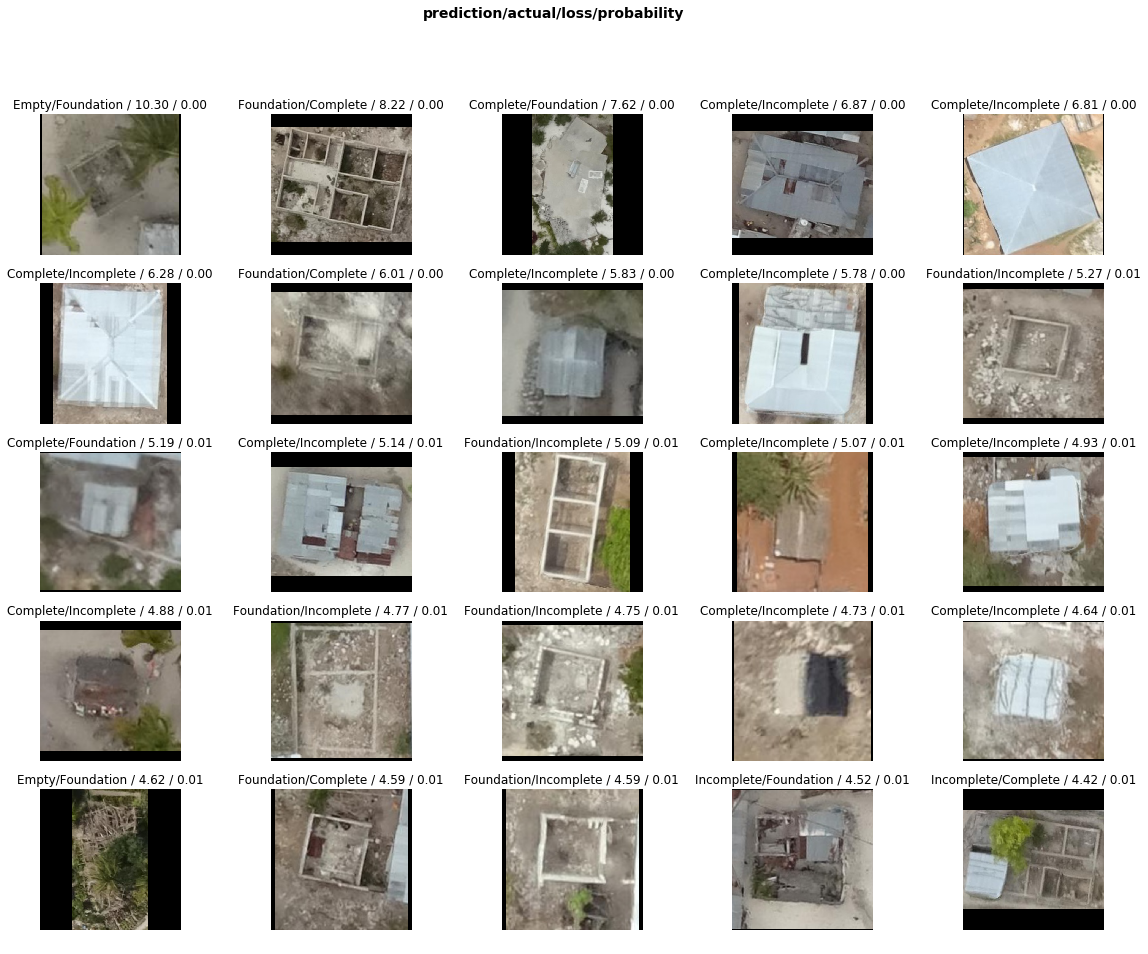

In [881]:
interp.plot_top_losses(25, figsize=(20,15))

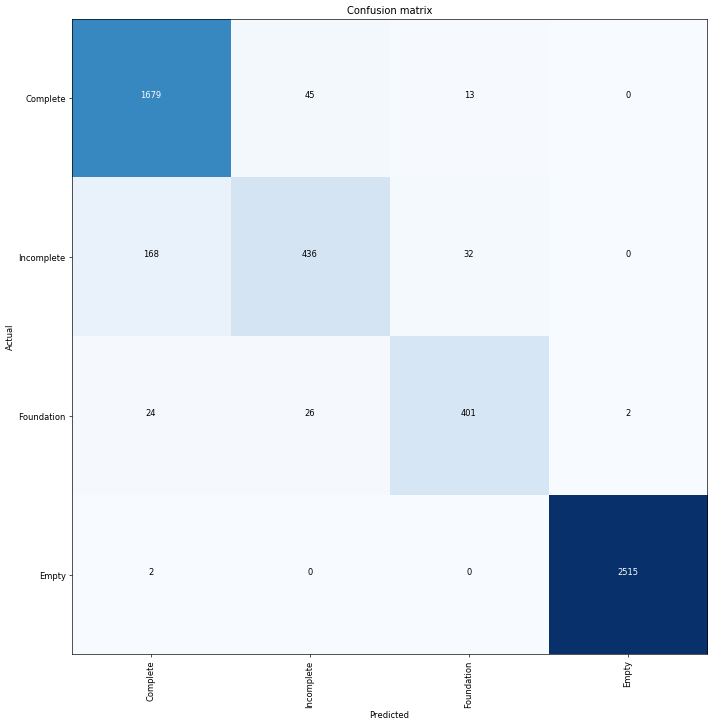

In [51]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [52]:
interp.most_confused(min_val=2)

[('Incomplete', 'Complete', 168),
 ('Complete', 'Incomplete', 45),
 ('Incomplete', 'Foundation', 32),
 ('Foundation', 'Incomplete', 26),
 ('Foundation', 'Complete', 24),
 ('Complete', 'Foundation', 13)]

## t-SNE Visualization (thanks to & adapted from @KarlH)

https://forums.fast.ai/t/share-your-work-here/27676/53

https://github.com/kheyer/ML-DL-Projects/blob/master/Pets%20TSNE/pets_tsne.ipynb

In [53]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [54]:
preds = interp.probs
y = interp.y_true
losses = interp.losses

In [55]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds)

In [56]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])
prob_df.head()

x          y  labels
0  79.168671  -4.132841     3.0
1   2.775866  33.078423     0.0
2 -29.614193  41.613716     0.0
3   3.576293  39.088879     0.0
4 -20.050320  31.020296     0.0

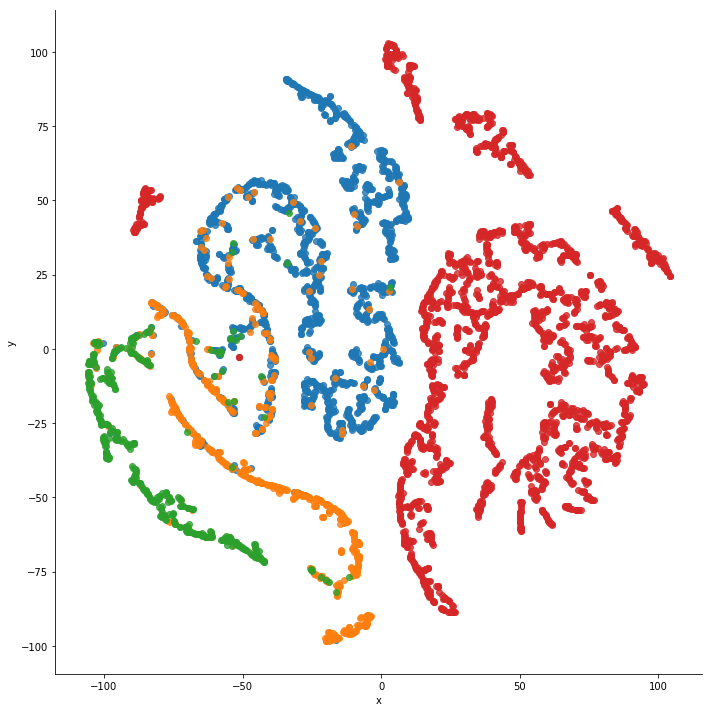

In [57]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

In [58]:
prob_df['fname'] = data.valid_ds.items
prob_df['loss'] = losses
prob_df.head()

x          y  labels  \
0  79.168671  -4.132841     3.0   
1   2.775866  33.078423     0.0   
2 -29.614193  41.613716     0.0   
3   3.576293  39.088879     0.0   
4 -20.050320  31.020296     0.0   

                                               fname      loss  
0  /storage/classify-data/images/grid028_00000_Em...  0.000004  
1  /storage/classify-data/images/grid028_00001_Co...  0.005743  
2  /storage/classify-data/images/grid028_00002_Co...  0.042030  
3  /storage/classify-data/images/grid028_00003_Co...  0.005064  
4  /storage/classify-data/images/grid028_00004_Co...  0.033498

In [62]:
# modified to optionally filter by idxs

def visualize_scatter_with_images(scaled_data, df, idxs, figsize=(64,64), image_zoom=1, suffix=1):
    scaled_data = scaled_data[idxs]
    df = df.iloc[idxs]

    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = (scaled_data[:,0])
    yy = (scaled_data[:,1])
    
    for (i,x,y) in zip(idxs,xx,yy):
        im = PIL.Image.open(df['fname'][i])
        im.thumbnail((64,64))
        img = OffsetImage(im, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    
#     fig.savefig(f'TSNE_{suffix}.jpg', bbox_inches = 'tight')
    return fig, ax

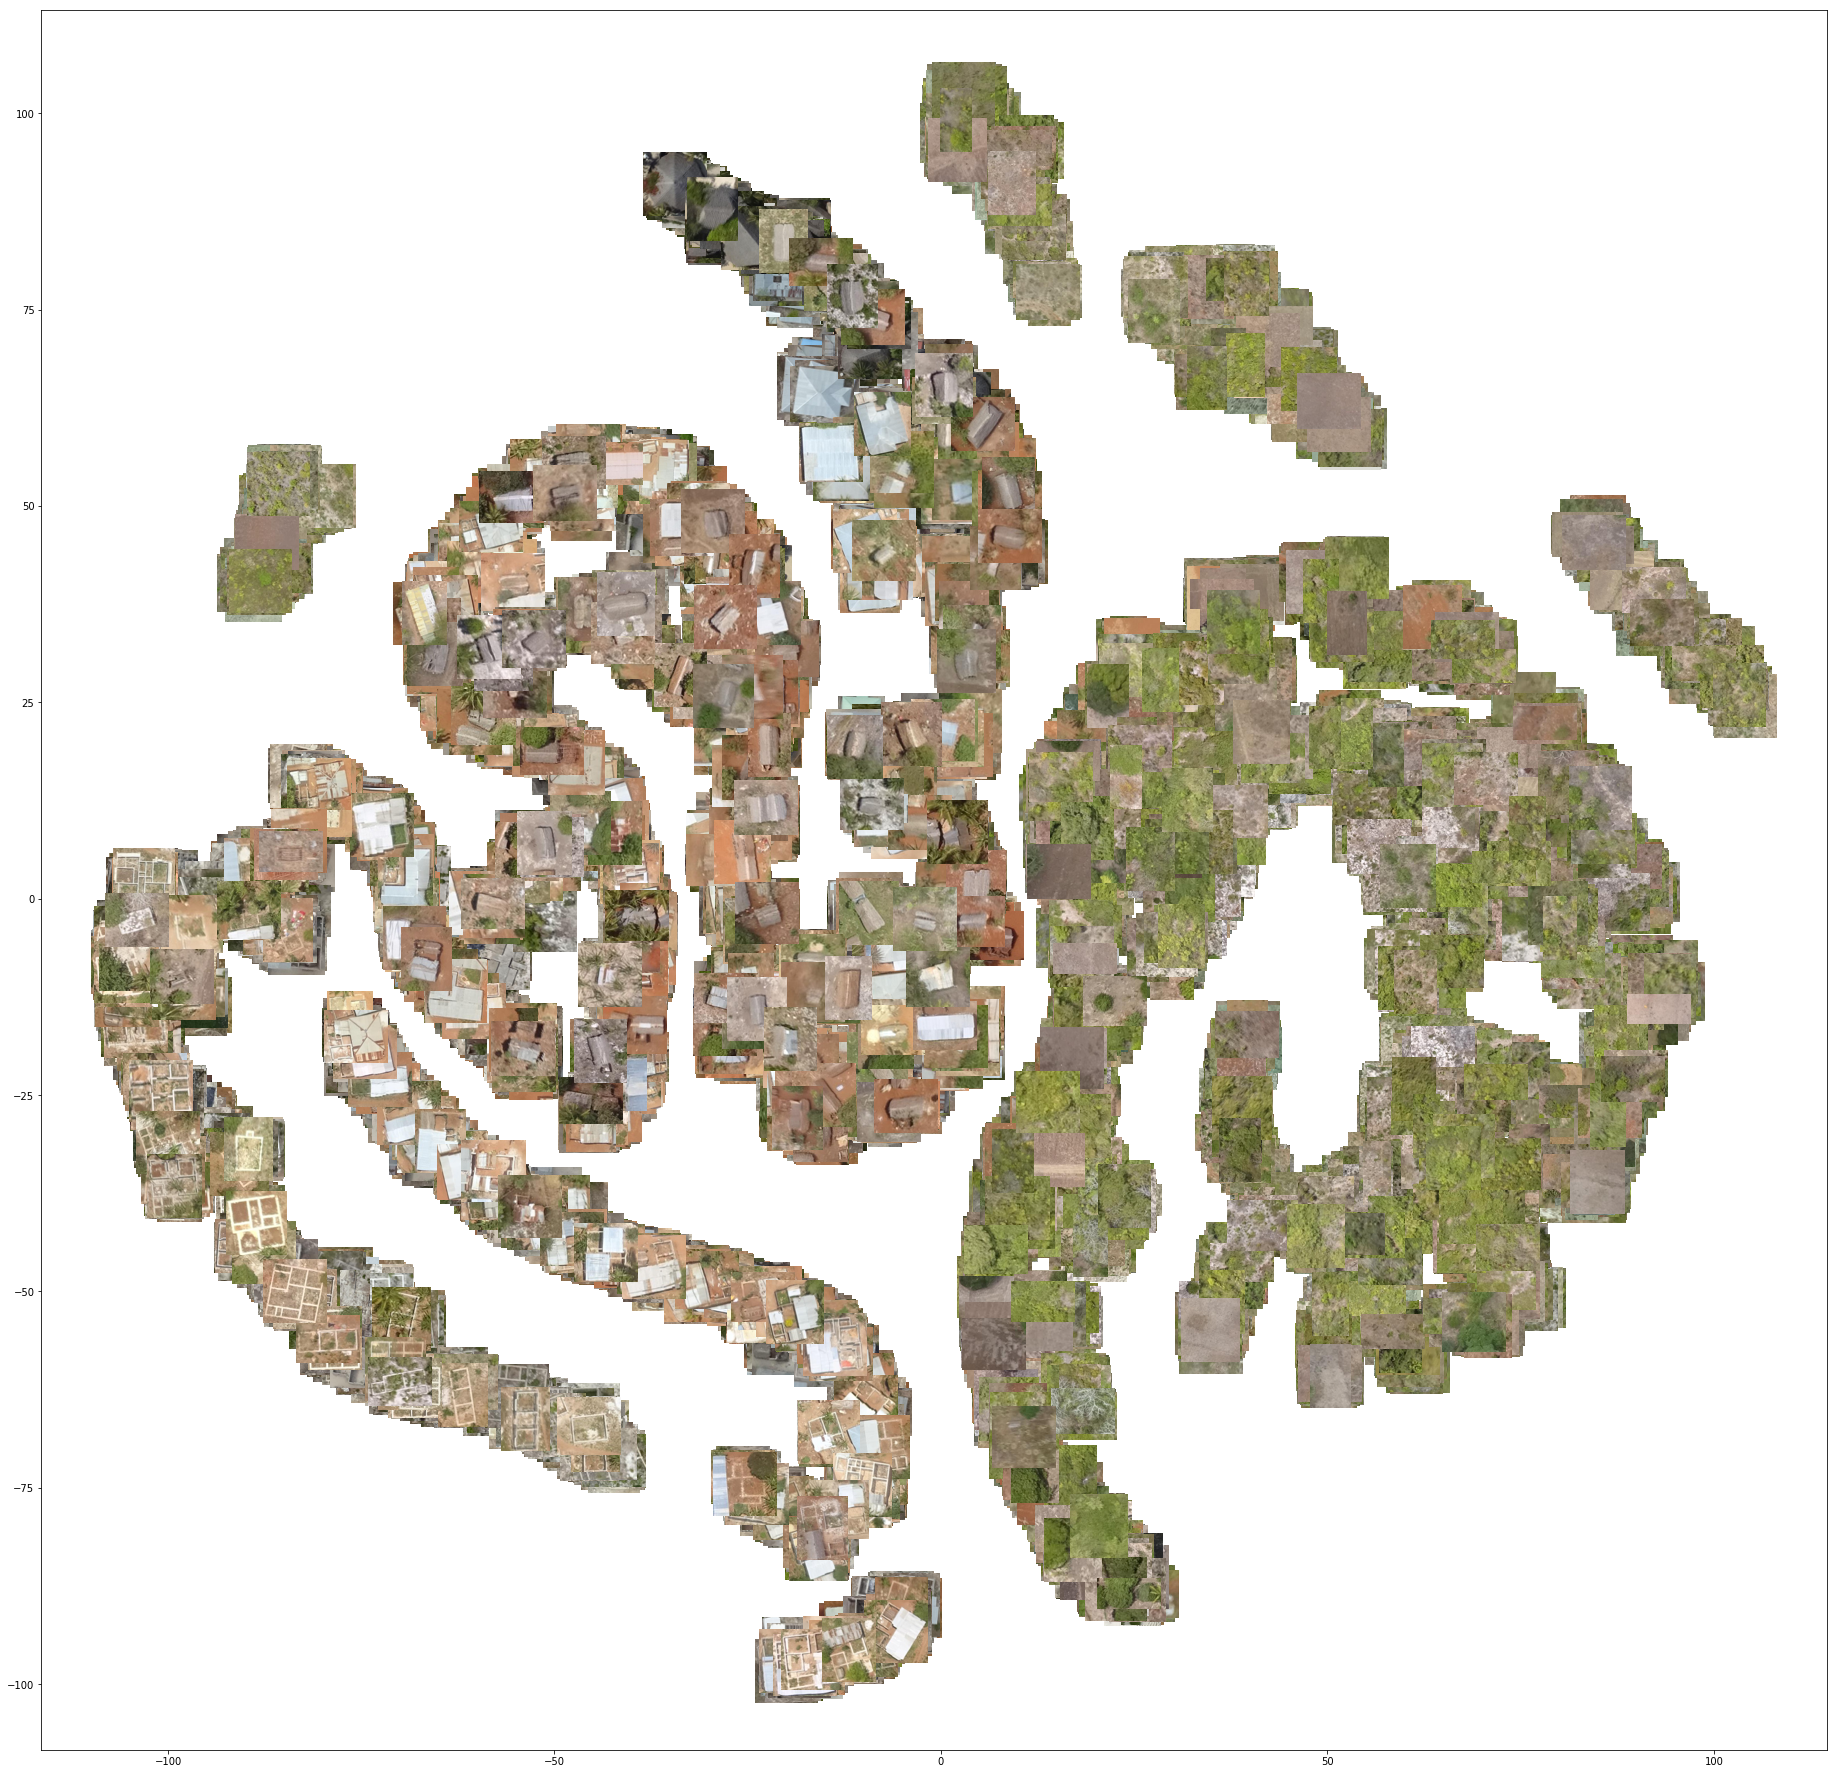

In [63]:
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, range(len(prob_df)), figsize=(32,32), image_zoom=1, suffix='probabilities')
plt.show()

In [64]:
top_losses = prob_df['loss'].sort_values(ascending=False)[:20].index.values

In [65]:
prob_df.iloc[top_losses]

x          y  labels  \
1676  17.063742 -82.787971     2.0   
2236 -89.942986 -44.406204     0.0   
2390   3.169056  21.009045     2.0   
1917 -10.888468  68.164185     1.0   
3955  -9.802946  45.570721     1.0   
1449  -8.742055  41.235390     1.0   
1542 -99.019615 -35.282078     0.0   
2484   6.600858  56.239902     1.0   
1460 -10.625313  20.081299     1.0   
2059 -44.045811 -70.368057     1.0   
2847 -33.260586  45.845680     2.0   
2546  -4.356708  13.330165     1.0   
1468 -45.562759 -66.899017     1.0   
3814   2.852378  19.537704     1.0   
2451  -3.919179  -4.506886     1.0   
1617   0.778873  -0.003726     1.0   
2793 -53.399986 -65.950081     1.0   
2052 -68.177902 -54.217014     1.0   
1477  -6.612920 -12.452487     1.0   
1487  -2.457771 -13.767251     1.0   

                                                  fname       loss  
1676  /storage/classify-data/images/grid029_00218_Fo...  10.302221  
2236  /storage/classify-data/images/grid029_00735_Co...   8.222069  
2390  /storage/classify-data/images/grid029_00880_Fo...   7.623971  
1917  /storage/classify-data/images/grid029_00440_In...   6.869032  
3955  /storage/classify-data/images/grid042_00397_In...   6.806755  
1449  /storage/classify-data/images/grid029_00008_In...   6.278516  
1542  /storage/classify-data/images/grid029_00094_Co...   6.007873  
2484  /storage/classify-data/images/grid029_00969_In...   5.825816  
1460  /storage/classify-data/images/grid029_00018_In...   5.776201  
2059  /storage/classify-data/images/grid029_00572_In...   5.272612  
2847  /storage/classify-data/images/grid029_01307_Fo...   5.189387  
2546  /storage/classify-data/images/grid029_01027_In...   5.142101  
1468  /storage/classify-data/images/grid029_00025_In...   5.086995  
3814  /storage/classify-data/images/grid042_00268_In...   5.074792  
2451  /storage/classify-data/images/grid029_00938_In...   4.932616  
1617  /storage/classify-data/images/grid029_00162_In...   4.877347  
2793  /storage/classify-data/images/grid029_01258_In...   4.765520  
2052  /storage/classify-data/images/grid029_00566_In...   4.746862  
1477  /storage/classify-data/images/grid029_00033_In...   4.729988  
1487  /storage/classify-data/images/grid029_00042_In...   4.638239

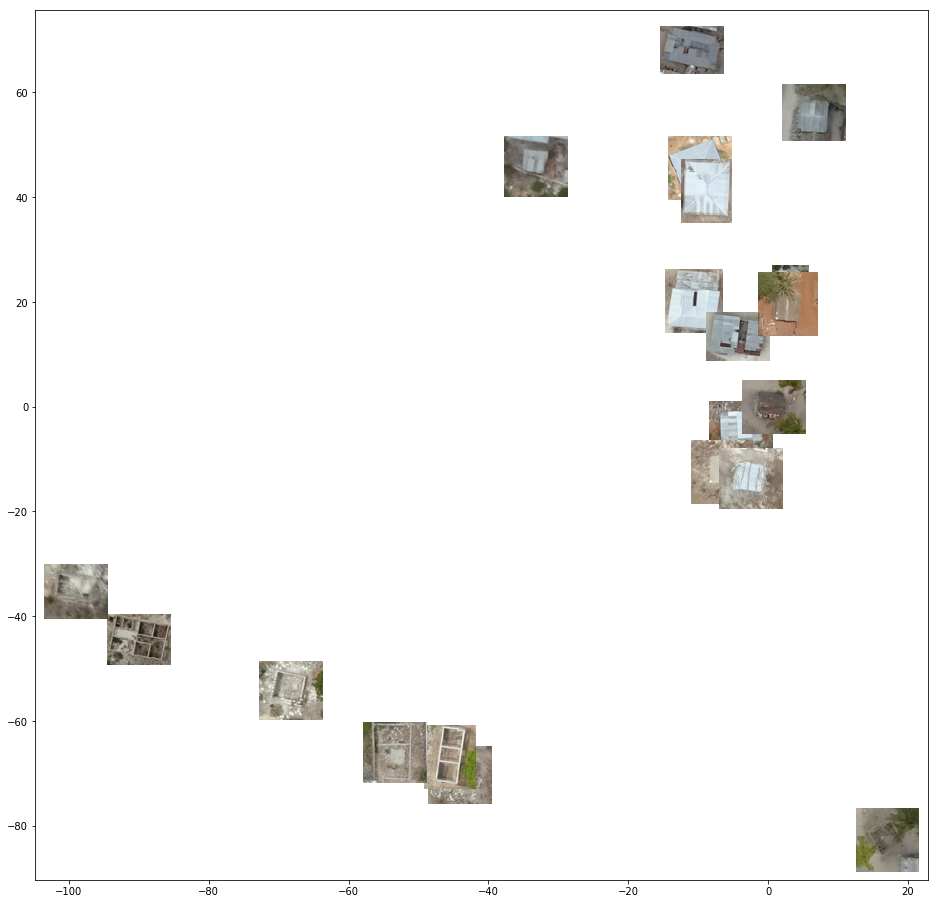

In [67]:
# show only images with top 20 losses at zoom = 2
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, top_losses, figsize=(16,16),image_zoom=1, suffix='probabilities')
plt.show()

## Grad-CAM (thanks to & adapted from Henri Palacci, @henripal)

https://forums.fast.ai/t/visualizing-intermediate-layers-a-la-zeiler-and-fergus/28140/34

https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb

In [70]:
# last bottleneck layer
target_layer = learn.model[0][-1][-1]
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [74]:
# define hooks for fmap and gradients

def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

fmap_hook = fastai.callbacks.hook_output(target_layer)
gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [886]:
# idx of a val image
idx = 2546
data.valid_ds.items[idx]

'/storage/classify-data/images/grid029_01027_Incomplete.jpg'

torch.Size([165, 213])


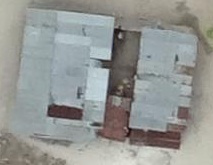

In [887]:
img = open_image(data.valid_ds.items[idx])
print(img.size)
img

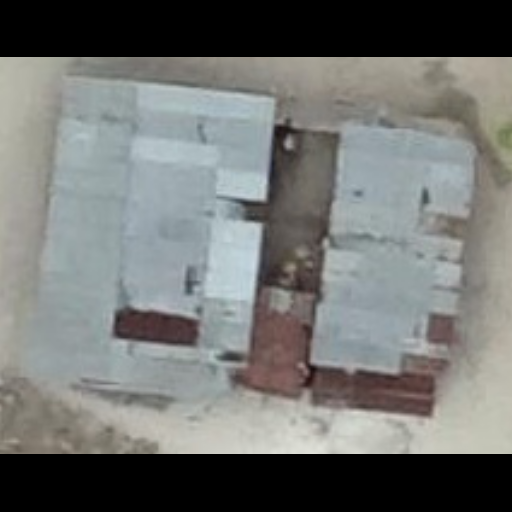

In [888]:
# apply val tfms to test image (same tfms from training but without data aug)
img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.PAD, padding_mode='zeros', size=512, bs=1)
img

In [889]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class, pred_idx, outputs

('Complete',
 tensor(0),
 tensor([9.9214e-01, 5.8454e-03, 2.0135e-03, 4.9060e-06]))

In [890]:
outputs

tensor([9.9214e-01, 5.8454e-03, 2.0135e-03, 4.9060e-06])

In [891]:
img.data.shape, img.data.unsqueeze(0).shape

(torch.Size([3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [892]:
# forward pass
learn.model.zero_grad();
out = learn.model(img.data.unsqueeze(0).cuda())

# we need to set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0
print(learn.data.classes[torch.argmax(out)])

# we then backprop from there
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

Complete


In [893]:
# get saved gradients
gradients = next(iter(gradient_hook.stored))
gradients.shape

torch.Size([1, 2048, 16, 16])

In [894]:
gradients.cpu().numpy().shape

(1, 2048, 16, 16)

In [895]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1) # sum gradients per channel (for 2048 channels)
print(gradients.shape, gradient_linearization.shape)
fmaps = fmap_hook.stored.cpu().numpy()
fmaps = fmaps.reshape(gradients.shape[1:])
print(fmaps.shape)

torch.Size([1, 2048, 16, 16]) (2048,)
(2048, 16, 16)


In [896]:
import scipy.ndimage

In [897]:
# relu on the heatmap
heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))

In [898]:
def upsample(heatmap, zoom=32):
    upsampled = scipy.ndimage.zoom(heatmap, zoom)
    upsampled = (upsampled - np.min(upsampled))/((np.max(upsampled) - np.min(upsampled))+1e-16)
    return upsampled

In [899]:
# we now upsample the heatmap so we can overlay it on our original image
upsampled = upsample(heatmap)

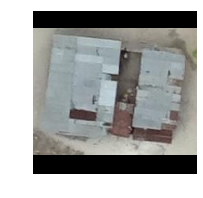

In [900]:
img.show()

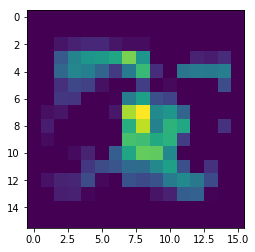

In [901]:
plt.imshow(heatmap)

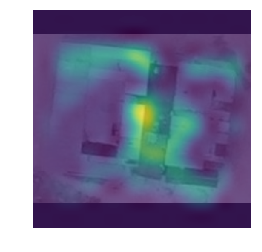

In [902]:
plt.imshow(np.moveaxis(to_np(img.data),0,2))
plt.imshow(upsampled, alpha=.7)
plt.gca().set_axis_off()

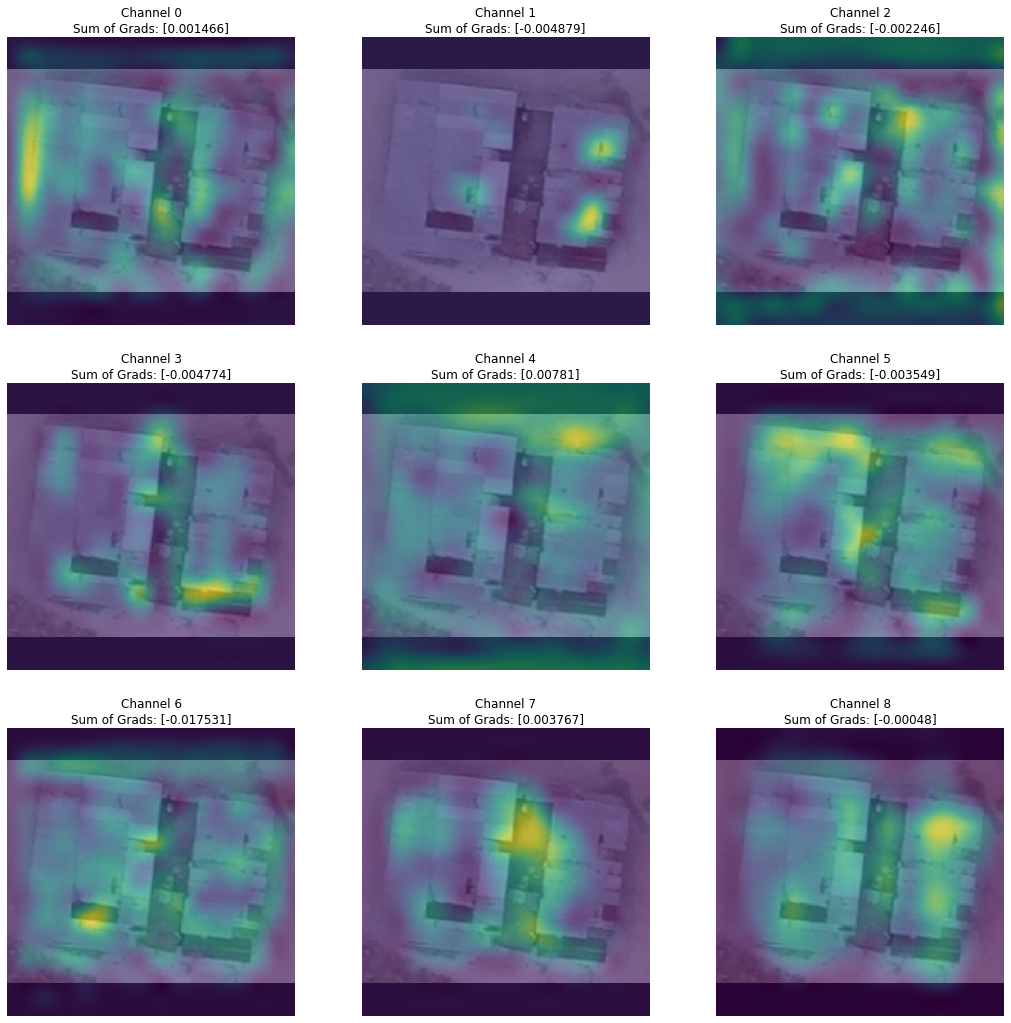

In [913]:
num_ch = min(fmaps.shape[0], 9)
fig, axes = plt.subplots(int(num_ch**0.5),int(num_ch**0.5), figsize=(2*num_ch,2*num_ch))
for j, ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img.show(ax=ax)
    ax.set_title('Channel '+str(j)+ '\n'+'Sum of Grads: '+str(grad_df.iloc[j].values))
    ax.imshow(upsample(fmaps[j]), alpha=0.6)
plt.show()

In [914]:
gradient_linearization.shape

(2048,)

In [915]:
grad_df = pd.DataFrame(gradient_linearization, columns=['gradient'])

In [916]:
grad_df.sort_values(by='gradient',ascending=False).shape

(2048, 1)

In [917]:
# get indices for all channels and sort by largest gradient first
importance_idxs = grad_df.sort_values(by='gradient',ascending=False).index.values

In [918]:
importance_idxs

array([ 275, 1098,  421, 1279, ..., 1395,  770,  798, 1924])

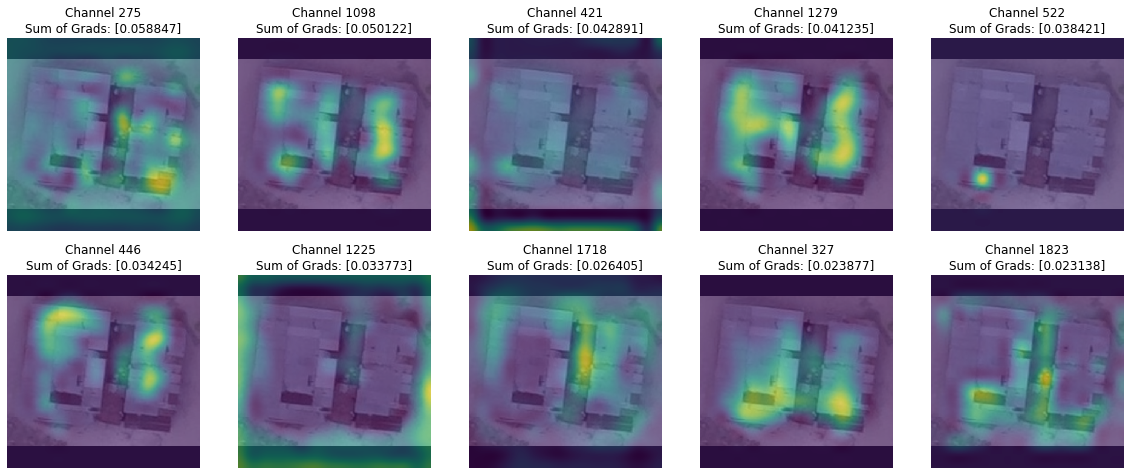

In [919]:
fig, axes = plt.subplots(2,5, figsize=(20,8))
for j, ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img.show(ax=ax)
    ax.set_title('Channel '+str(importance_idxs[j])+ '\n'+'Sum of Grads: '+str(grad_df.loc[importance_idxs[j]].values))
    ax.imshow(upsample(fmaps[importance_idxs[j]]), alpha=0.6)
plt.show()

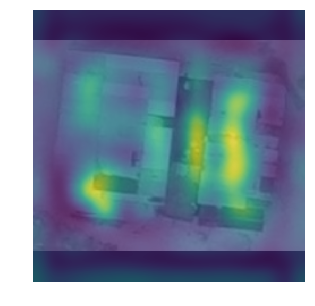

In [920]:
fm_up = [upsample(fm) for fm in fmaps[importance_idxs[:10]]]
img.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.7)

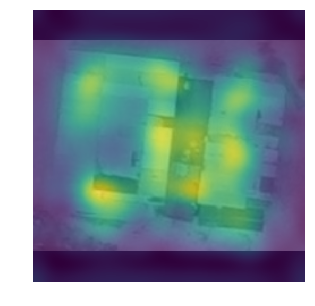

In [921]:
fm_up = [upsample(fm) for fm in fmaps[importance_idxs[:100]]]
img.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.7)

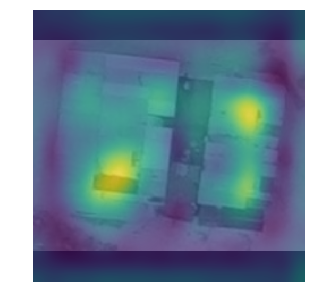

In [922]:
fm_up = [upsample(fm) for fm in fmaps[importance_idxs[-100:]]]
img.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.7)

## Test time

In [220]:
data.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

In [221]:
learn.load('20181119-rn50-stage1')
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [222]:
grid_num = '119'
test_path = Path(f'/storage/znz-classify-001/demo_test/test_{grid_num}')
test_fns = [o for o in sorted(test_path.iterdir()) if '.jpg' in o.name]
print(len(test_fns))

13552


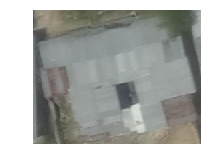

In [223]:
img = open_image(test_fns[100])
img.show()
plt.show()

In [224]:
learn.predict(img)

('Complete',
 tensor(0),
 tensor([9.9551e-01, 2.7130e-03, 1.7597e-03, 2.1532e-05]))

In [225]:
from tqdm import tqdm

In [226]:
preds = []
pred_classes = []
for fn in tqdm(test_fns[:100]):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.PAD, padding_mode='zeros', size=512, bs=1)
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(pred_class)
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


In [227]:
np.round(preds,2)

array([[0.99, 0.01, 0.  , 0.  ],
       [0.98, 0.02, 0.  , 0.  ],
       [0.39, 0.61, 0.  , 0.  ],
       [0.01, 0.01, 0.99, 0.  ],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.  , 0.95],
       [0.99, 0.01, 0.  , 0.  ],
       [0.09, 0.91, 0.  , 0.  ]], dtype=float32)

In [228]:
df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [o.name for o in test_fns[:len(preds)]]
df['predicted_class'] = pred_classes

In [229]:
df.head()

Complete  Incomplete  Foundation     Empty               fname  \
0  0.987873    0.009546    0.002547  0.000034  119_00000_test.jpg   
1  0.978718    0.020046    0.001220  0.000016  119_00001_test.jpg   
2  0.387141    0.607828    0.004947  0.000084  119_00002_test.jpg   
3  0.008926    0.005472    0.985536  0.000066  119_00003_test.jpg   
4  0.934160    0.063721    0.002100  0.000020  119_00004_test.jpg   

  predicted_class  
0        Complete  
1        Complete  
2      Incomplete  
3      Foundation  
4        Complete

Complete 0.9878727197647095


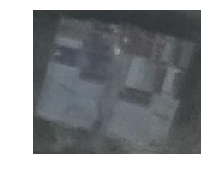

Complete 0.9787178039550781


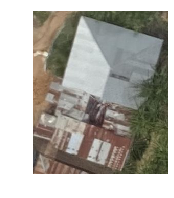

Incomplete 0.6078280210494995


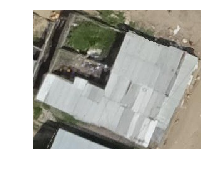

Foundation 0.9855361580848694


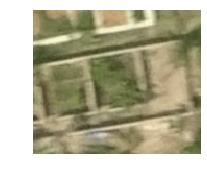

Complete 0.9341595768928528


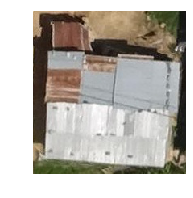

Foundation 0.9833261370658875


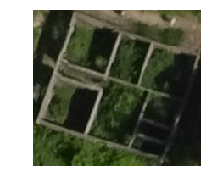

Complete 0.915702223777771


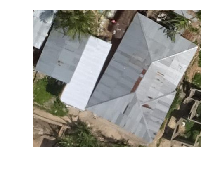

Incomplete 0.584927499294281


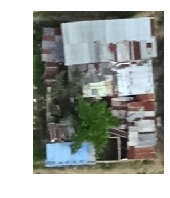

Incomplete 0.7525575160980225


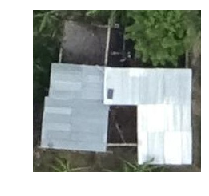

Complete 0.9976527094841003


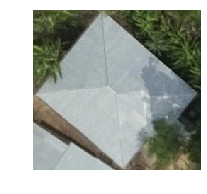

In [231]:
for i in range(10):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()

In [220]:
df.to_csv('preds.csv',index=False)